**2.156 Final Project**

Load Data from dropbox

In [ ]:
import os
import shutil
import random
import pathlib
import requests
from urllib.parse import urlencode, urlparse, parse_qsl, urlunparse

data_dir = "https://www.dropbox.com/scl/fo/3d3kttc96e8a5izrhr9du/ABGbVWFKYaUZNu9jtNVnwDY?rlkey=lvo18dm41lb4jbyarzznvwtvx&st=gv5sxb2t&dl=0"
source_root = "data/source_dataset"
target_root = "data/split_dataset"
def _to_direct_dropbox(url):
    parsed = urlparse(url)
    if "dropbox.com" not in parsed.netloc:
        return url
    query = dict(parse_qsl(parsed.query))
    query["dl"] = "1"
    return urlunparse(parsed._replace(query=urlencode(query)))

download_url = _to_direct_dropbox(data_dir)
source_root_path = pathlib.Path(source_root)
zip_path = source_root_path.parent / "source_dataset.zip"
source_root_path.mkdir(parents=True, exist_ok=True)

with requests.get(download_url, stream=True) as resp:
    resp.raise_for_status()
    with open(zip_path, "wb") as fh:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                fh.write(chunk)

shutil.unpack_archive(str(zip_path), str(source_root_path))
zip_path.unlink()

gitignore_path = pathlib.Path(".gitignore")
gitignore_entries = {source_root.rstrip("/"), target_root.rstrip("/")}
existing = set()
if gitignore_path.exists():
    existing = {line.strip() for line in gitignore_path.read_text().splitlines() if line.strip()}
with gitignore_path.open("a") as f:
    for entry in sorted(gitignore_entries):
        if entry not in existing:
            f.write(entry + "\n")

splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

# Create target folders
for split in splits:
    for class_name in os.listdir(source_root):
        os.makedirs(os.path.join(target_root, split, class_name), exist_ok=True)

# Split the data per class
for class_name in os.listdir(source_root):
    class_dir = os.path.join(source_root, class_name)
    if not os.path.isdir(class_dir):
        continue
        
    images = os.listdir(class_dir)
    random.shuffle(images)

    n = len(images)
    n_train = int(n * ratios["train"])
    n_val   = int(n * ratios["val"])

    train_files = images[:n_train]
    val_files   = images[n_train:n_train+n_val]
    test_files  = images[n_train+n_val:]

    for f in train_files:
        shutil.copy(os.path.join(class_dir, f), 
                    os.path.join(target_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(class_dir, f), 
                    os.path.join(target_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(class_dir, f), 
                    os.path.join(target_root, "test", class_name, f))
print("Dataset split completed.")

Files: ['Victaulic_FP_Cplg Rgd_IR_Style 109 (OGS)_1.25 (32)', 'Victaulic_IPS-AGS_Cplg Rgd_Style W07 (AGS)_18 (450)', 'Victaulic_IPS-AGS_Cplg Rgd_Style W07 (AGS)_14 (350)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_8 (200)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_24 (600)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_10 (250)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_4 (100)', 'Victaulic_IPS-AGS_Cplg Rgd_Style W07 (AGS)_30 (750)', 'Victaulic_IPS_Cplg Rgd QV_Style 107V (OGS)_12 (300)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_6 (150)']


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Images 

In [14]:
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

base_dir = "/Users/rebeccasholler/Library/CloudStorage/Dropbox/CouplingRenderings/Renderings_split"



train_data = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=train_transform)
val_data   = datasets.ImageFolder(os.path.join(base_dir, "val"),   transform=eval_transform)
test_data  = datasets.ImageFolder(os.path.join(base_dir, "test"),  transform=eval_transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)


In [13]:
print(train_data.classes)
print(len(train_data))
images, labels = next(iter(train_loader))
print(images.shape)


['Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_12 (300)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_14 (350)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_16 (400)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_18 (450)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_20 (500)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_24 (600)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_30 (750)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_36 (900)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_4 (100)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_6 (150)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_1.5 (40)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_10 (250)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_12 (300)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_2 (50)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_3 (80)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_4 (100)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_6 (150)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009V 

We will want to visualize the data next but will add that in when data is complete

**ResNet18**
no weights but apparently that is something I could add

In [18]:
from torchvision import models
import torch.nn as nn

num_classes = len(train_data.classes)

model = models.resnet18(weights=None)   # No download → no SSL issue
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [20]:
def train_model_resnet(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, device="cuda"):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- VALIDATION -----
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies


In [21]:
from torchvision import models
import torch.nn as nn

num_classes = len(train_data.classes)

model = models.resnet18(weights=None)  
model.fc = nn.Linear(model.fc.in_features, num_classes)

train_losses, val_losses, val_acc = train_model_resnet(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=10, 
    learning_rate=1e-4, 
    device=device
)


Epoch 1/10 | Train Loss: 4.1408 | Val Loss: 4.0286 | Val Acc: 0.0265
Epoch 2/10 | Train Loss: 3.7362 | Val Loss: 3.6939 | Val Acc: 0.0341
Epoch 3/10 | Train Loss: 3.3852 | Val Loss: 3.3037 | Val Acc: 0.0871
Epoch 4/10 | Train Loss: 3.1090 | Val Loss: 3.0176 | Val Acc: 0.0947
Epoch 5/10 | Train Loss: 2.8591 | Val Loss: 2.8863 | Val Acc: 0.1364
Epoch 6/10 | Train Loss: 2.6568 | Val Loss: 3.1333 | Val Acc: 0.0530
Epoch 7/10 | Train Loss: 2.5136 | Val Loss: 3.1931 | Val Acc: 0.0909
Epoch 8/10 | Train Loss: 2.4232 | Val Loss: 2.4944 | Val Acc: 0.1894
Epoch 9/10 | Train Loss: 2.2417 | Val Loss: 2.5471 | Val Acc: 0.1705
Epoch 10/10 | Train Loss: 2.1243 | Val Loss: 2.5977 | Val Acc: 0.1894


In [22]:
import torch
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


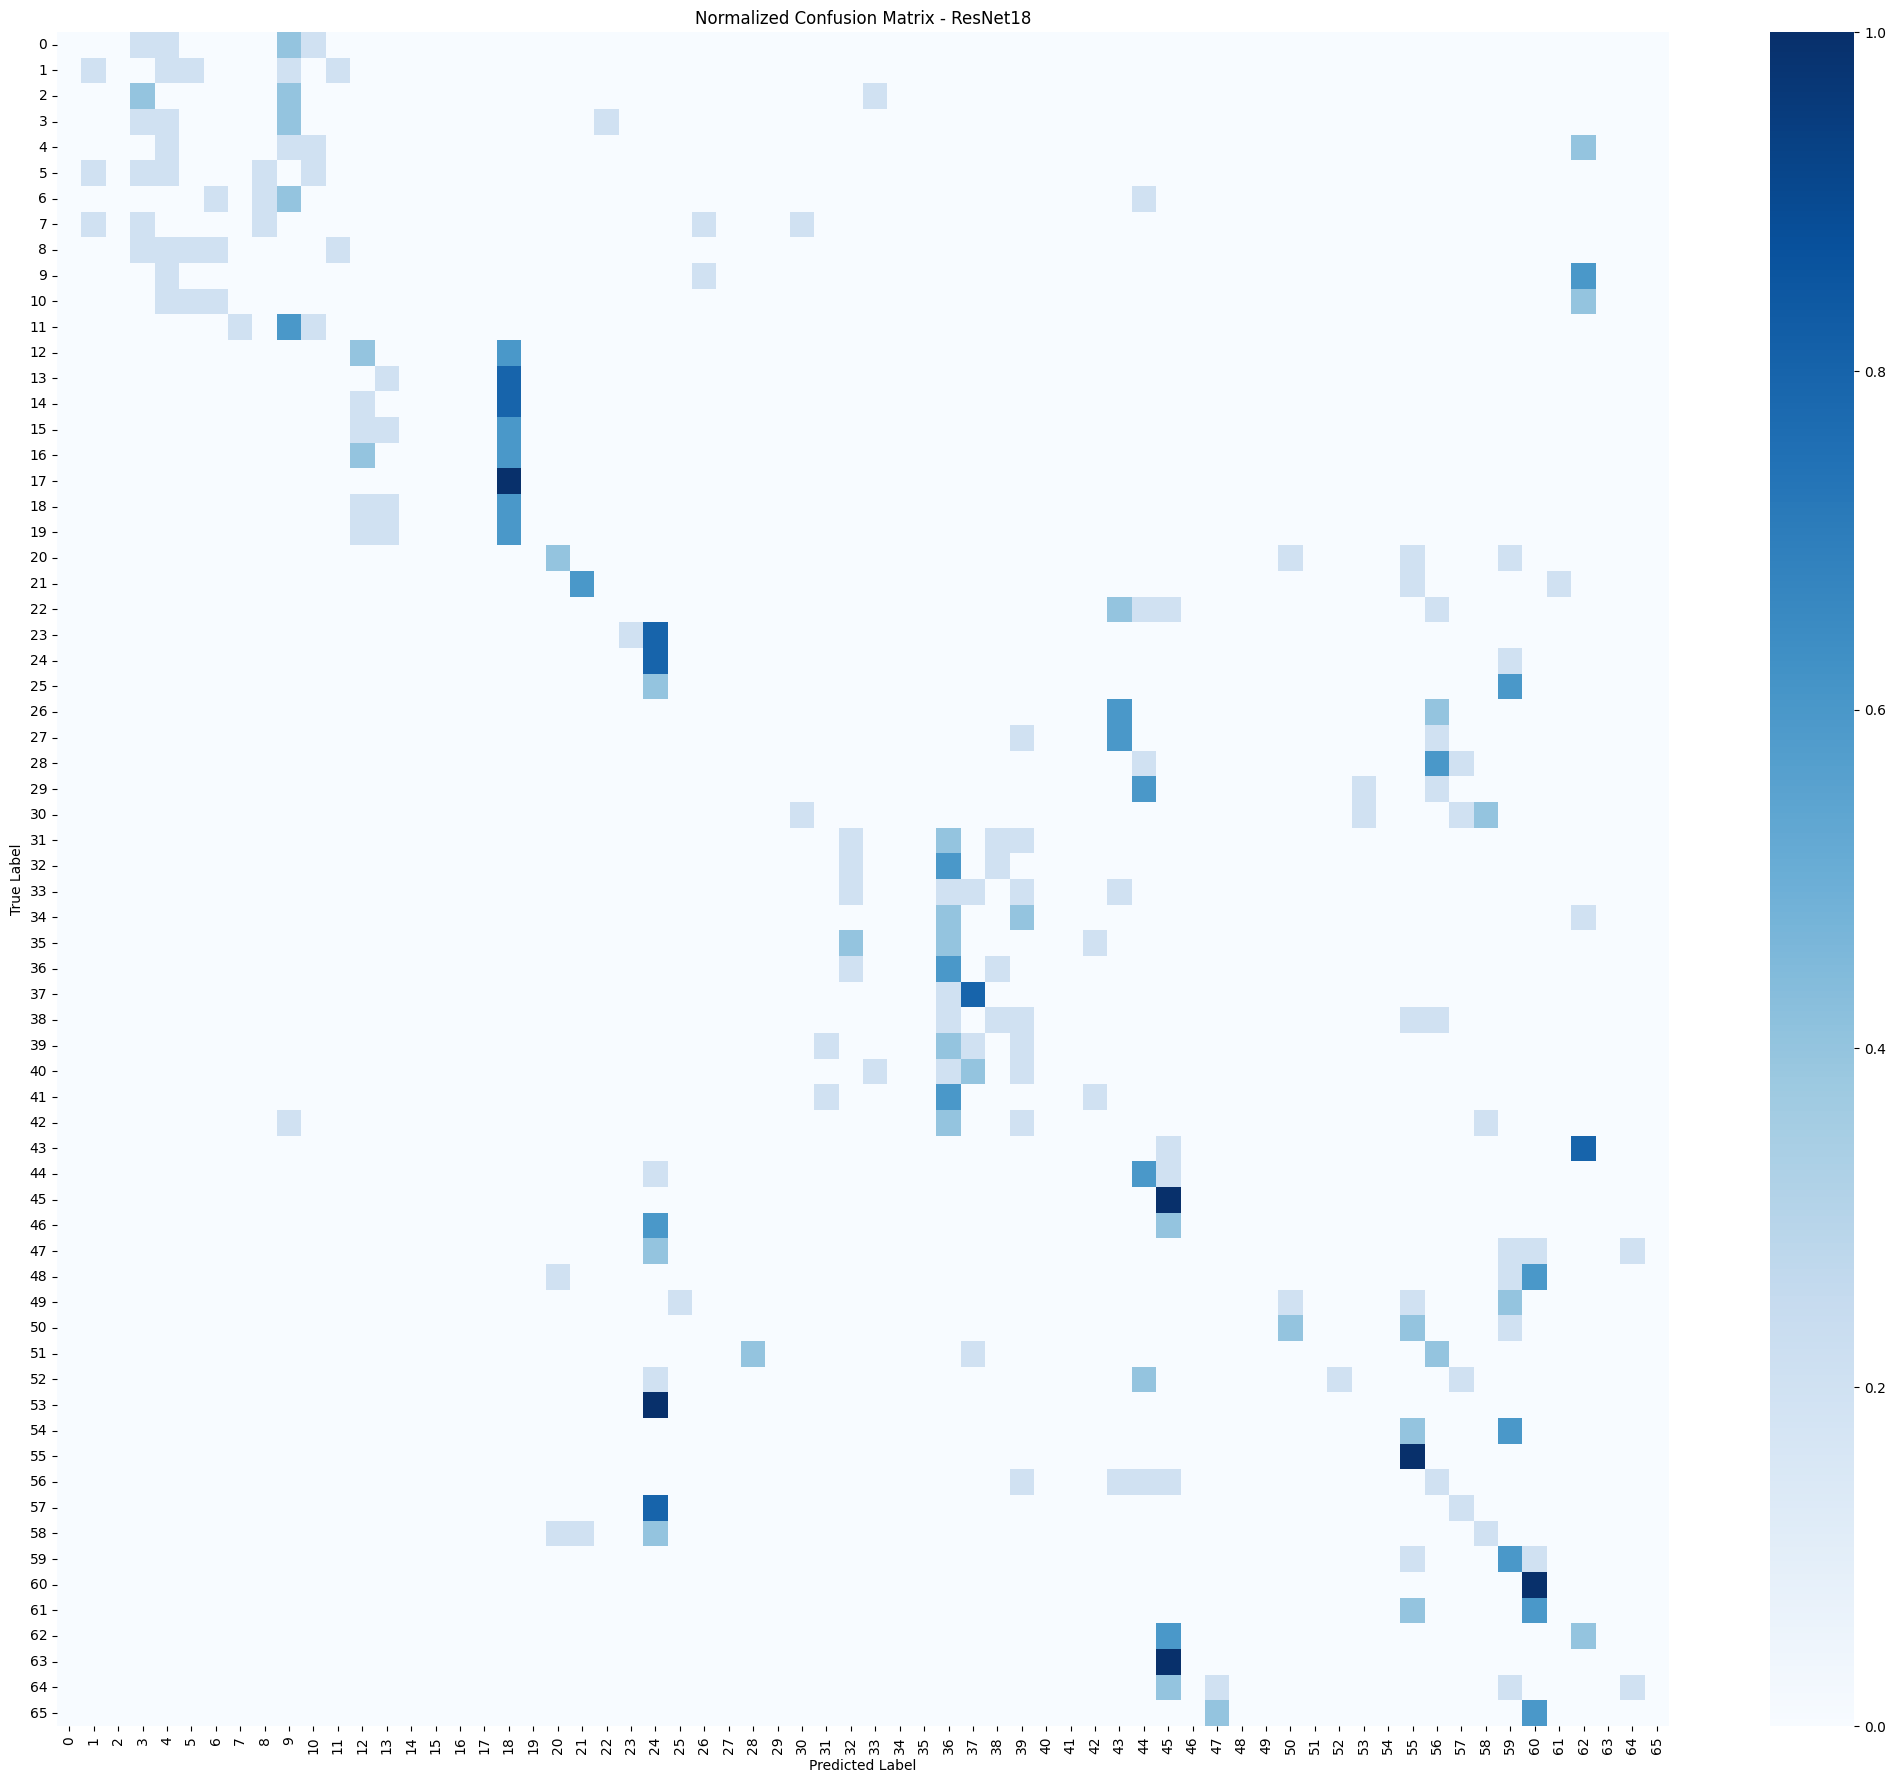

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
cm.shape

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(26, 22))
sns.heatmap(cm_norm, 
            cmap="Blues") 
            #xticklabels=class_names,
            
            #yticklabels=class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix - ResNet18")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [28]:
correct = cm.diagonal().sum()
total = cm.sum()
print("Overall Test Accuracy:", correct / total)


Overall Test Accuracy: 0.18484848484848485


Below this is the CNN from the demo, I did not use this yet.

In [4]:
class CNN(nn.Module):
    def __init__(self):  # Define all the layers here
        super(CNN, self).__init__()
        # All pooling will use 2x2 window and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Conv layer: 3 input channel (RBG), 4 output channels, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1)

        # Second Conv layer: 4 input channels, 8 output channels
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

        # Third Conv layer: 8 input channels, 16 output channels
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Fourth Conv layer: 16 input channels, 32 output channels
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Operation to flatten the images into a vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 3 * 3, 16)  # Adjusted to match the output size after conv3
        self.fc2 = nn.Linear(16, 75)  # 75 output classes??
        #WILL NEED TO EDIT based on number of parts we decide on

    def forward(self, x):  # Call all the layers in this function
        # Reshape the input to ensure it has the correct channel dimension: [batch x 1 x 50 x 50]
        if len(x.shape) == 3:  # Input is [batch x 50 x 50]
            x = x.unsqueeze(1)  # Add channel dimension -> [batch x 1 x 50 x 50]

        # Convolve, then pass through ReLU, then pooling
        x = F.relu(self.conv1(x))  # [batch x 4 x 50 x 50]
        x = self.pool(x)  # [batch x 4 x 25 x 25]

        x = F.relu(self.conv2(x))  # [batch x 8 x 25 x 25]
        x = self.pool(x)  # [batch x 8 x 12 x 12]

        x = F.relu(self.conv3(x))  # [batch x 16 x 12 x 12]
        x = self.pool(x)  # [batch x 16 x 6 x 6]

        x = F.relu(self.conv4(x))  # [batch x 32 x 6 x 6]
        x = self.pool(x)  # [batch x 32 x 3 x 3]

        x = self.flatten(x)  # Flatten for the fully connected layer [batch x 288]

        # Pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))  # [batch x 16]

        # Final fully connected layer with no activation (since we are doing regression)
        x = self.fc2(x)  # Output layer with 5 outputs [batch x 5]
        return x

# Create a CNN model instance
model_cnn = CNN()
model_cnn.to(device)

# Print the model's architecture
#summary(model_cnn, input_size=(1, 50, 50))  # Adjusted input size for grayscale images with 1 channel


CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=75, bias=True)
)

Create Training Loop

In [5]:
def train_model(model, X_train, Y_train, X_validation, Y_validation, num_epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    """
    Function to train a given model (CNN or DNN) using training and validation data.

    Args:
    - model: The model to train (e.g., CNN or DNN).
    - X_train: Training data (features).
    - Y_train: Training data (labels).
    - X_validation: Validation data (features).
    - Y_validation: Validation data (labels).
    - num_epochs: Number of training epochs (default: 10).
    - batch_size: Batch size for training (default: 32).
    - learning_rate: Learning rate for the optimizer (default: 0.001).
    - device: Device to run the model on ('cuda' or 'cpu').

    Returns:
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    """

    # Move model to the specified device (GPU or CPU)
    model = model.to(device)

    # Define loss function (Mean Squared Error for regression tasks)
    criterion = nn.MSELoss()

    # Define optimizer (Adam optimizer with specified learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for batching the training data
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for batching the validation data
    validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(Y_validation, dtype=torch.float32))
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store train and validation losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Using tqdm for the training loop progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)

        # Iterate over batches of training data
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
            labels = labels.to(device)  # Move labels to device (GPU/CPU)

            # Zero the gradients before the next update
            optimizer.zero_grad()

            # Forward pass: compute model outputs
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Perform a single optimization step (update model parameters)
            optimizer.step()

            # Accumulate loss over the batch
            running_loss += loss.item() * inputs.size(0)

            # Update tqdm progress bar with current loss
            train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader.dataset)})

        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation loop (no gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute model outputs
                outputs = model(inputs)

                # Compute validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss for the epoch
        val_loss /= len(validation_loader.dataset)
        val_losses.append(val_loss)

        # Print the train and validation loss at the end of each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train MSE: {epoch_loss:.4f} - Validation MSE: {val_loss:.4f}')

    print("Training complete.")

    # Return the recorded training and validation losses
    return train_losses, val_losses


Plot Convergence

In [ ]:
def plot_convergence(train_losses, val_losses):
    """
    Function to plot the training and validation loss convergence over epochs.

    Args:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot training and validation losses
    plt.plot(train_losses, label='Train Mean Squared Error (MSE)', color="black")
    plt.plot(val_losses, label='Validation Mean Squared Error (MSE)', color="red")

    # Label the axes
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Add legend in the upper right corner
    plt.legend(loc='upper right')

    # Remove the top and right borders
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()


Plot Predictions With R-squared: scatterplots to compare our model's predicted values with the ground truth values from the validation set

In [6]:
def plot_predictions_with_r2(model, X_validation, Y_validation, X_test, Y_test, device, names=None, show_test=True):
    """
    Function to plot actual vs predicted values for validation and optionally test datasets,
    display R² scores in the subplot titles, and add a legend in the last (unused) subplot.

    Args:
    - model: The trained model (DNN or CNN) used for making predictions.
    - X_validation: Validation feature data.
    - Y_validation: Validation target data.
    - X_test: Test feature data.
    - Y_test: Test target data.
    - device: The device (GPU or CPU) on which the model is running.
    - names: List of names for the target variables (default: None).
    - show_test: Boolean flag to control whether to show test data or only validation data (default: True).
    """

    if names is None:
        names = ["C11", "C12", "C22", "C66", "Volume Fraction"]  # Default names for target variables

    # Generate predictions for the validation and test sets
    val_pred = model(torch.tensor(X_validation, dtype=torch.float32).to(device)).cpu().detach().numpy()

    if show_test:
        test_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

    # Create a figure with 2x3 subplots (6 in total)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    # Loop over the target variables (assuming 5 here)
    for i in range(5):
        # Calculate the R² score for validation and test sets
        r2_val = r2_score(Y_validation[:, i], val_pred[:, i])

        if show_test:
            r2_test = r2_score(Y_test[:, i], test_pred[:, i])

        # Plot actual vs predicted for validation (and optionally test) sets
        ax = axs[i // 3, i % 3]  # Subplot position

        if show_test:
            # Plot test data if the flag is set to True
            ax.scatter(Y_test[:, i], test_pred[:, i], s=3, color="#32a895", alpha=0.2, label='Test')

            # Plot the ideal 1:1 line (using ranges from test)
            ax.plot([min(test_pred[:, i]), max(test_pred[:, i])],
                    [min(test_pred[:, i]), max(test_pred[:, i])], color='#f73946', linestyle='--', label='Target Line')
        else:
            # Plot the ideal 1:1 line (using ranges from val)
            ax.plot([min(val_pred[:, i]), max(val_pred[:, i])],
                    [min(val_pred[:, i]), max(val_pred[:, i])], color='#f73946', linestyle='--', label='Target Line')

        # Plot validation data
        ax.scatter(Y_validation[:, i], val_pred[:, i], s=3, color="black", alpha=0.2, label='Validation')

        # Set labels for the axes
        ax.set_xlabel(f"Actual {names[i]}")
        ax.set_ylabel(f"Predicted {names[i]}")

        # Add the R² scores to the title of each subplot
        if show_test:
            ax.set_title(f"{names[i]} - R² Val: {r2_val:.2f}, R² Test: {r2_test:.2f}")
        else:
            ax.set_title(f"{names[i]} - R² Val: {r2_val:.2f}")

        # Remove the top and right borders for a cleaner look
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Add legend in the last subplot (bottom right, unfilled one)
    axs[1, 2].axis('off')  # Turn off the empty subplot
    handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from previous plots

    # Make points in the legend larger by adjusting 'scatterpoints' and 'markerscale'
    axs[1, 2].legend(handles, labels, loc='center', scatterpoints=3, markerscale=4, handletextpad=1.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

